In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob

In [2]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/djk2120/workers/', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46457 instead
  warnings.warn(
/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be re

In [12]:
def amean(da):
    #annual mean
    m  = da['time.daysinmonth']
    xa = 1/365*(m*da).groupby('time.year').sum().compute()
    xa.name=da.name
    xa.attrs=da.attrs
    return xa


In [14]:
def gmean(da,la):
    x=1/la.sum()*(da*la).sum(dim=['lat','lon']).compute()
    x.name=da.name
    x.attrs=da.attrs
    return x

In [8]:
def pp(ds):
    dvs=['TLAI','GPP','NBP','TOTVEGC','TOTSOMC']
    return ds[dvs]

In [46]:
x='/glade/scratch/djk2120/archive/TRENDY2023_f09_{}/lnd/hist/*h0*'
dsets={sim:xr.open_mfdataset(sorted(glob.glob(x.format(sim))),
                             combine='by_coords',
                             parallel=True,
                             preprocess=pp)
       for sim in ['S0','S1']}
for sim in dsets:
    dsets[sim]['time']=xr.cftime_range('1701',periods=len(dsets[sim].time),freq='MS',calendar='noleap')

In [47]:
ds=xr.concat([dsets[sim] for sim in dsets],dim='sim')
ds['sim']=[sim for sim in dsets]

In [48]:
f=glob.glob(x.format('S0'))[0]
tmp=xr.open_dataset(f)
la=tmp.area*tmp.landfrac

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 12.52 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(0.0, 150.0)

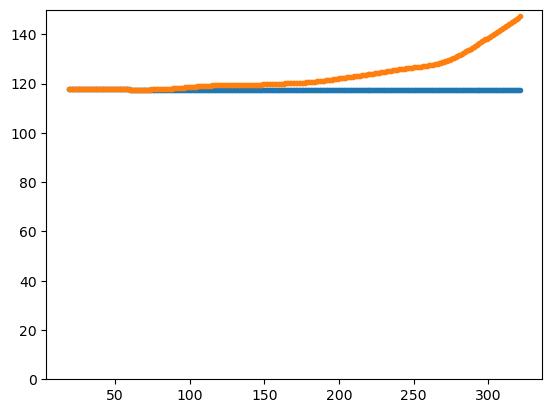

In [52]:
cf=1e-9*la.sum()*24*60*60*365
x=cf*gmean(amean(ds.GPP),la)
plt.plot(x.rolling({'year':20}).mean(),'.')
plt.ylim([0,150])

In [53]:
cf=1e-9*la.sum()*24*60*60*365
x=cf*gmean(amean(ds.NBP),la)

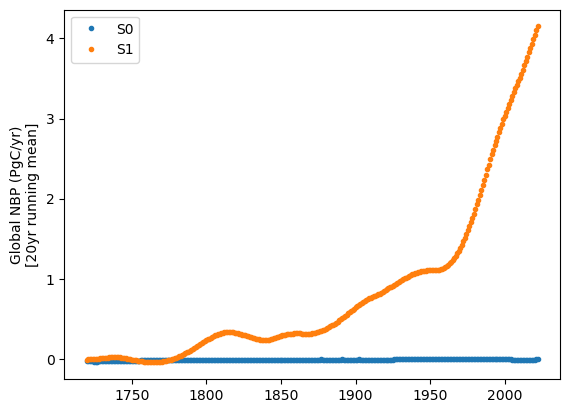

In [60]:
plt.plot(x.year,x.rolling({'year':20}).mean(),'.')
plt.legend(ds.sim.values)
plt.ylabel('Global NBP (PgC/yr)\n[20yr running mean]');